#### **Import Libraries**

In [1]:
# Standard library imports
import os

# Deep learning libraries
import torch
from torch.utils.data import DataLoader
import transformers
from transformers import AutoModelForSequenceClassification, AutoTokenizer, DataCollatorWithPadding

# Text processing libraries
import tiktoken
import csv
import pandas as pd

# Utility libraries
import numpy as np
import random
import math
from tqdm import tqdm
from itertools import chain
from IPython.display import display, Markdown
import textwrap

# Custom libraries  
from llmft.train import EncoderTrainer, EarlyStopping
from llmft.metrics import compute_recall, compute_f1_score
from llmft.losses import FocalLoss
from llmft.utils import predict

# Visualization libraries
import seaborn as sns  # Assuming seaborn is installed

# NLP utility (assuming trics is a library/module)
from trics.nlp.utils import to_markdown

# Configure GPU usage and tokenizer parallelism
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["TOKENIZERS_PARALLELISM"] = "false"

# Suppress warnings
import warnings
warnings.filterwarnings("ignore")

# Dataset libraries (can be grouped together)
from sklearn.model_selection import train_test_split
from datasets import Dataset, DatasetDict, concatenate_datasets, load_dataset
import torch.nn.utils as utils

#### **Parameters**

In [2]:
seed = 1                        # Seed
sample_size = 10_000              # Sample Size
val_set_fraction = 0.25         # Fraction of sample used for validation set
lr = 2e-4                       # Optimizer learning rate
warmup_ratio = 0.25             # Fraction of training epochs used for learning rate warm up
batch_size = 32                 # Number of observations in each mini-batch
epochs = 50                     # Number of training epochs
patience = 30                    
gamma = 0.0


#### **Set Up Plotting**

In [3]:
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import rcParams
rcParams['image.interpolation'] = 'nearest'
rcParams['image.cmap'] = 'viridis'
rcParams['axes.grid'] = False
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
plt.style.use('seaborn-v0_8-dark-palette')

from matplotlib import font_manager 
locations = './../../../styles/Newsreader'
font_files = font_manager.findSystemFonts(fontpaths=locations)
print(locations)
print(font_files[0])
for f in font_files: 
    font_manager.fontManager.addfont(f)
plt.rcParams["font.family"] = "Newsreader"

./../../../styles/Newsreader
/home/ubuntu/llmft/styles/Newsreader/static/Newsreader_9pt/Newsreader_9pt-Bold.ttf


#### **Set Up Device**

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

Device: cuda


#### **Tokenizer**

In [5]:
model_id = "roberta-base"#"distilbert/distilbert-base-uncased"#
tokenizer = AutoTokenizer.from_pretrained(model_id)
tokenizer.model_max_length = 512
print(tokenizer.model_max_length)

def tokenizer_function(example):
  return tokenizer(example["text"], truncation=True)

512


#### **Preprocess Data**

In [6]:

# Load the dataset
dataset = load_dataset("imdb")

# Define the sample size
sample_size = 1000

# Function to sample a fixed number of observations
def sample_dataset(dataset, sample_size):
    # Ensure the sample size is not larger than the dataset
    assert sample_size <= len(dataset), "Sample size is larger than the dataset size"
    # Get a random sample of indices
    random_indices = random.sample(range(len(dataset)), sample_size)
    # Select the sampled indices from the dataset
    return dataset.select(random_indices)

# Sample the datasets
train_dataset = sample_dataset(dataset['train'], sample_size)
test_dataset = sample_dataset(dataset['test'], sample_size)

tokenized_train_dataset = train_dataset.map(tokenizer_function, batched=True)
tokenized_train_dataset = tokenized_train_dataset.remove_columns(['text'])


tokenized_test_dataset = test_dataset.map(tokenizer_function, batched=True)
tokenized_test_dataset = tokenized_test_dataset.remove_columns(['text'])

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

#### **DataLoaders**

In [7]:
train_loader = DataLoader(tokenized_train_dataset, batch_size=batch_size, collate_fn=DataCollatorWithPadding(tokenizer), shuffle=True)
val_loader = DataLoader(tokenized_test_dataset, batch_size=batch_size, collate_fn=DataCollatorWithPadding(tokenizer), shuffle=True)

#### **Model**

In [8]:
model = AutoModelForSequenceClassification.from_pretrained(model_id,
                                                           num_labels=2)
model = model.to(device)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


#### **Optimizer and Scheduler**

In [9]:
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = transformers.optimization.get_cosine_schedule_with_warmup(optimizer,int(warmup_ratio*len(train_loader)*epochs), len(train_loader)*epochs)

#### **Class Weights**

In [10]:
criterion = torch.nn.CrossEntropyLoss()

#### **Trainer**

In [11]:
metric_fn =  lambda a, b: (compute_f1_score(a,b), compute_recall(a,b))
yuri = EncoderTrainer(model, optimizer, scheduler, metric_fn, criterion, device, False)
early_stopping = EarlyStopping(patience)

#### **Train**

In [12]:
# Compute Initial Train/Validation Losses
evaluation_losses = [yuri.evaluate(val_loader)]
training_losses =  [yuri.evaluate(train_loader)]
pbar =  tqdm(range(epochs), desc=f'Epoch: 0, Train Loss: {training_losses[0]:.3f}, Val Loss: {evaluation_losses[0]:.3f}')

# Initialize Empty Lists to Store Recall and Learning Rate Histories
metric_history = []
learning_rate_history = []

for epoch in pbar:

    train_loss, metrics, current_lr = yuri.train(train_loader)

    training_losses.append(train_loss)
    metric_history.append(metrics)
    learning_rate_history.append(current_lr)
    
    val_loss = yuri.evaluate(val_loader)
    evaluation_losses.append(val_loss)

    # Update the progress bar description for the current epoch
    pbar.set_description(f'Epoch: {epoch + 1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

    
    # Call early stopping
    early_stopping(val_loss, model, epoch)
    if early_stopping.early_stop:
        print("***Early stopping***")
        print(f"Min Validation Loss: {early_stopping.best_epoch}")
        print(f"Current Epoch: {epoch}")
        break

model.load_state_dict(torch.load('checkpoint.pt'))

Epoch: 18, Train Loss: 0.6986, Val Loss: 0.6993:  36%|███▌      | 18/50 [09:05<16:10, 30.32s/it]


KeyboardInterrupt: 

#### **Loss History**

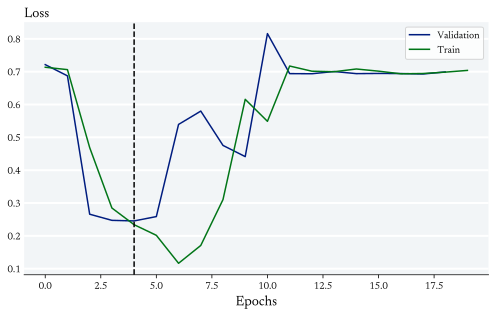

In [13]:
fig = plt.figure(dpi=300, tight_layout=True, figsize=(7, 4.5))
ax = plt.axes(facecolor=(.95, .96, .97))

# Set visibility of some spines
for key in 'left', 'right', 'top':
    ax.spines[key].set_visible(False)

# Add text to the axes
ax.text(0., 1.02, s='Loss', transform=ax.transAxes, size=14)

# Set Y-axis tick parameters and grid
ax.yaxis.set_tick_params(length=0)
ax.yaxis.grid(True, color='white', linewidth=2)
ax.set_axisbelow(True)
plt.plot(evaluation_losses, label='Validation')
plt.plot(training_losses, label='Train')
plt.axvline(early_stopping.best_epoch + 1, color='black', linestyle='--')
plt.legend()
plt.xlabel('Epochs', size=14)
plt.show()

#### **F1-Score**

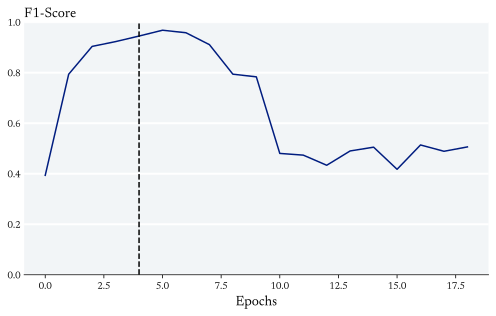

In [14]:
fig = plt.figure(dpi=300, tight_layout=True, figsize=(7, 4.5))
ax = plt.axes(facecolor=(.95, .96, .97))

# Set visibility of some spines
for key in 'left', 'right', 'top':
    ax.spines[key].set_visible(False)

# Add text to the axes
ax.text(0., 1.02, s='F1-Score', transform=ax.transAxes, size=14)

# Set Y-axis tick parameters and grid
ax.yaxis.set_tick_params(length=0)
ax.yaxis.grid(True, color='white', linewidth=2)
ax.set_axisbelow(True)
plt.plot([i[0] for i in metric_history])
plt.axvline(early_stopping.best_epoch + 1, color='black', linestyle='--')
plt.xlabel('Epochs', size=14)
plt.ylim(0, 1)
plt.show()

#### **Recall**

In [ ]:
fig = plt.figure(dpi=300, tight_layout=True, figsize=(7, 4.5))
ax = plt.axes(facecolor=(.95, .96, .97))

# Set visibility of some spines
for key in 'left', 'right', 'top':
    ax.spines[key].set_visible(False)

# Add text to the axes
ax.text(0., 1.02, s='Recall', transform=ax.transAxes, size=14)

# Set Y-axis tick parameters and grid
ax.yaxis.set_tick_params(length=0)
ax.yaxis.grid(True, color='white', linewidth=2)
ax.set_axisbelow(True)
plt.plot([i[1][0][0] for i in metric_history], label='0')
plt.plot([i[1][0][1] for i in metric_history], label='1')
plt.axvline(early_stopping.best_epoch + 1, color='black', linestyle='--')
plt.xlabel('Epochs', size=14)
plt.legend()
plt.show()